<a href="https://colab.research.google.com/github/DmitriyValetov/nlp_course_project/blob/master/nmt_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
1. Check embeddings by dimension reduction (Are they adequate?) (Maybe use pre-trained?) 
2. Check attention matrix visually (Is it adequate?) (Maybe change attention algorithm to local or add context vector to decoder input?) 
3. Add cos similarity distance as attention type.
4. If already have attention maybe we don't need to add encoder's hidden state (h1) to decoder input?
5. Try summarization task. I think we need to use embedded (How?) sequence of sentences to encoder input, maybe simple sentences words embeddings sum.
6. Try using subword vocabulary
7. Try external attention (e.g. simple dict)
8. Try multi attention (e.g. cos + dist or external + dist)

How to improve baseline model?

* Use `pad_packed_sequence` and `pack_padded_sequence` methods in Encoder and Decoder.
* Use attention! In `src/models.py` file you can find class for GlobalAttention. I **STRONGLY RECOMMEND** to read this [article](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html). (**DO NOT FORGET ABOUT ATTENTION MASKS FOR PAD TOKENS!**)
* The baseline model is trained by [teacher forcing](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/) method, you can also read about [Professor forcing](https://arxiv.org/abs/1610.09038).
* You can find something interesting [here](https://arxiv.org/abs/1409.3215) and [here](https://arxiv.org/abs/1409.0473).
* Implement bidirectional GRU/LSTM in encoder.
* You can try to use self-attention in encoder or decoder (**DO NOT FORGET ABOUT ATTENTION MASKS FOR PAD TOKENS!**).
* Write validation loop (for example, check loss on validation dataset):)
* You can try to implement [beam-search](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)/[nucleus sampling](https://arxiv.org/abs/1904.09751).
* Hyper-parameter tuning.
* Read about BLEU metric and realize, how you can score it better (see the last cell).

Baseline model

Encoder baseline model contains: Embedding -> GRU -> SpatialDropout  
Decoder: Embedding -> GRU -> pre-head layer -> head layer (with [weight tying](https://arxiv.org/abs/1608.05859))

You can edit everything you want, your main task is get the highest BLEU score.

![alt text](https://docs.google.com/drawings/u/0/d/sZ5dsXuaAP0zVG82SctfeKA/image?w=602&h=388&rev=6&ac=1&parent=1gURxb15No18tqqRDd36t4bzT0XghhDJPgzXRggbj0VU)

![alt text](https://docs.google.com/drawings/u/0/d/scpWiFNRIINBzLR-Tgulruw/image?w=602&h=369&rev=350&ac=1&parent=1gURxb15No18tqqRDd36t4bzT0XghhDJPgzXRggbj0VU)

|idx|token|
|:-:|---|
| 0 | \<PAD\> |
| 1 | \<GO\> |
| 2 | \<EOS\> |
| 3 | \<UNK\> |
|...| words/subwords/multiwords |



In [0]:
# !pip install torchviz
# from torchviz import make_dot

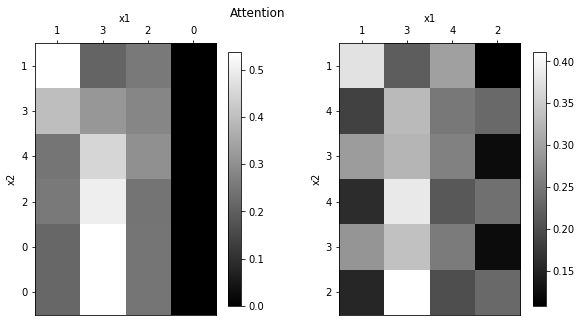

In [348]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, padding_idx,
               rnn_type, hidden_size, num_layers=1, rnn_dropout=0,
               bidirectional=False, dropout=0, pack=False):
    super(EncoderRNN, self).__init__()
    rnn_map = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                  embedding_dim=embedding_dim,
                                  padding_idx=padding_idx)
    self.rnn = rnn_map[rnn_type](input_size=embedding_dim, 
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 dropout=rnn_dropout,
                                 bidirectional=bidirectional)
    self.dropout = nn.Dropout(dropout)
    self.pack = pack

  def forward(self, x1):  # [B, L]
    x = self.embedding(x1)  # [B, L] -> [B, L, E]
    if self.pack:  # [B, L, E] -> Packed [B, L, E]
      ls = torch.sum(x1 != 0, dim=1)
      x = pack_padded_sequence(x, ls, batch_first=True, enforce_sorted=False)
    # [B, L, E] -> (Packed) [B, L, ND*H], ([NL*ND, B, H], ([NL*ND, B, H]))
    if isinstance(self.rnn, nn.LSTM):
      ht, (hn, cn) = self.rnn(x)
      hn, cn = self.dropout(hn), self.dropout(cn)
      return ht, (hn, cn)
    else:
      ht, hn = self.rnn(x)
      hn = self.dropout(hn)
      return ht, hn


class AttentionDecoderRNN(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, padding_idx,
               rnn_type, hidden_size, num_layers=1, rnn_dropout=0,
               bidirectional=False, dropout=0, out_hidden=0,
               attn_type='soft_dot', pack=False):
    super(AttentionDecoderRNN, self).__init__()
    rnn_map = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}
    attn_types = ['dot', 'cos', 'dist', 'soft_dot', 'soft_cos', 'soft_dist', 'none']
    self.attn_type = attn_type
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                  embedding_dim=embedding_dim,
                                  padding_idx=padding_idx)
    self.rnn = rnn_map[rnn_type](input_size=embedding_dim, 
                                 hidden_size=hidden_size,
                                 num_layers=num_layers,
                                 batch_first=True,
                                 dropout=rnn_dropout,
                                 bidirectional=bidirectional)
    out_input = hidden_size if self.attn_type == 'none' else 2*hidden_size
    if out_hidden > 0:
      self.out_hidden = nn.Linear(out_input, out_hidden)
      self.out = nn.Linear(out_hidden, num_embeddings)
    else:
      self.out_hidden = None
      self.out = nn.Linear(out_input, num_embeddings)
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.LogSoftmax(dim=2)
    self.pack = pack

  def forward(self, x2, h1, x1):  # [B, L], [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    x = self.embedding(x2)  # [B, L] -> [B, L, E]
    if self.pack:  # [B, L, E] -> Packed [B, L, E]
      lengths = torch.sum(x2 != 0, dim=1)
      x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    ht1, hns1 = h1  # [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    # [B, L, D], ([NL*ND, B, H], [NL*ND, B, H]) -> [B, L, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    ht2, hns2 = self.rnn(x, hns1)
    if self.pack:  # Packed [B, L, E] -> [B, L, E]
      ht1, _ = pad_packed_sequence(ht1, batch_first=True)
      ht2, _ = pad_packed_sequence(ht2, batch_first=True)
    if self.attn_type == 'none':
      if self.rnn.bidirectional:
        B2, L2, NDH2 = ht2.size()
        # [B, L, ND*H] -> [B, L, ND, H] -> [B, L, H]
        ht2 = ht2.view(B2, L2, 2, int(NDH2/2)).mean(2)
      x = self.dropout(ht2)
      if self.out_hidden is not None:
        x = self.out_hidden(x)
      x = self.out(x)
      y2 = self.softmax(x)
      return y2, None
    else:
      if self.rnn.bidirectional:
        B1, L1, NDH1 = ht1.size()
        B2, L2, NDH2 = ht2.size()  # B1 == B2, NDH1 == NDH2
        # [B, L, ND*H] -> [B, L, ND, H] -> [B, L, H]
        ht1 = ht1.view(B1, L1, 2, int(NDH1/2)).mean(2)
        ht2 = ht2.view(B2, L2, 2, int(NDH2/2)).mean(2)
      # [L2, H], [L1, H] -> [L2, L1]
      # mask where x1 and x2 token is <PAD>
      # pad_mask = torch.einsum('bi,bj->bij', x2, x1) == 0
      # mask where only x1 token is <PAD>
      pad_mask = torch.einsum('bi,bj->bij', torch.ones_like(x2), x1) == 0
      # [B, L2, H], [B, L1, H] -> [B, L2, L1]  # attention
      # [B, L2, L1], [B, L1, H] -> [B, L2, H]  # weighted h1
      if self.attn_type == 'dot':
        attn = torch.einsum('bih,bjh->bij', ht2, ht1)  # dot product
        attn[pad_mask] = 0
      elif self.attn_type == 'soft_dot':
        attn = torch.einsum('bih,bjh->bij', ht2, ht1)  # dot product
        attn[pad_mask] = float('-inf')
        attn = F.softmax(attn, 2)
      elif self.attn_type == 'dist':
        ht1, ht2 = ht1.contiguous(), ht2.contiguous()
        attn = torch.cdist(ht2, ht1)  # euclidian distance
        attn = torch.masked_fill(attn, pad_mask, float('inf'))
        attn = F.threshold(attn, threshold=1e-6, value=1e-6)  # short dist
        attn = 1/attn  # inverse
        attn = F.normalize(attn, p=1, dim=2)  # to [0, 1]
      elif self.attn_type == 'soft_dist':
        ht1, ht2 = ht1.contiguous(), ht2.contiguous()
        attn = torch.cdist(ht2, ht1)  # euclidian distance
        attn = torch.masked_fill(attn, pad_mask, float('inf'))
        attn = F.softmin(attn, 2)
      elif self.attn_type == 'cos':
        ht1n = F.normalize(ht1, p=2, dim=2)  # normalize to length = 1
        ht2n = F.normalize(ht2, p=2, dim=2)  # normalize to length = 1
        attn = torch.einsum('bih,bjh->bij', ht2n, ht1n)  # dot product
        attn[pad_mask] = 0
      elif self.attn_type == 'soft_cos':
        ht1n = F.normalize(ht1, p=2, dim=2)  # normalize to length = 1
        ht2n = F.normalize(ht2, p=2, dim=2)  # normalize to length = 1
        attn = torch.einsum('bih,bjh->bij', ht2n, ht1n)  # dot product
        attn[pad_mask] = float('-inf')
        attn = F.softmax(attn, 2)
      hw1 = torch.einsum('bij,bjh->bih', attn, ht1)  # weighted h1
      ha = torch.cat((ht2, hw1), 2)  # [B, L2, H], [B, L2, H] -> [B, L2, H+H]
      x = self.dropout(ha)  # [B, L2, H+H] -> [B, L2, H+H]
      if self.out_hidden is not None:
        x = self.out_hidden(x)   # [B, L2, H+H] -> [B, L2, OH]
      x = self.out(x)  # [B, L2, H+H] or [B, L2, OH] -> [B, L2, D2]
      y2 = self.softmax(x)  # [B, L2, D2] -> [B, L2, D2]
      return y2, attn


class EncoderDecoder(nn.Module):
  def __init__(self, 
               enc_num_embeddings, enc_embedding_dim, enc_padding_idx,
               dec_num_embeddings, dec_embedding_dim, dec_padding_idx,
               rnn_type, hidden_size, num_layers=1, out_hidden=0,
               enc_rnn_dropout=0, dec_rnn_dropout=0,
               bidirectional=False, enc_dropout=0, dec_dropout=0, 
               attn_type='dot', pack=False):
    super(EncoderDecoder, self).__init__()
    self.encoder = EncoderRNN(num_embeddings=enc_num_embeddings, 
                              embedding_dim=enc_embedding_dim, 
                              padding_idx=enc_padding_idx,
                              hidden_size=hidden_size, 
                              rnn_type=rnn_type, 
                              bidirectional=bidirectional,
                              num_layers=num_layers,
                              dropout=enc_dropout,
                              rnn_dropout=enc_rnn_dropout,
                              pack=pack)
    self.decoder = AttentionDecoderRNN(num_embeddings=dec_num_embeddings, 
                                       embedding_dim=dec_embedding_dim, 
                                       padding_idx=dec_padding_idx,
                                       hidden_size=hidden_size, 
                                       rnn_type=rnn_type, 
                                       bidirectional=bidirectional,
                                       num_layers=num_layers,
                                       dropout=dec_dropout,
                                       out_hidden=out_hidden,
                                       rnn_dropout=dec_rnn_dropout,
                                       attn_type=attn_type,
                                       pack=pack)

  def forward(self, x1, x2):
    #  [B, L1] -> [B, L1, ND*H], ([NL*ND, B, H], [NL*ND, B, H])
    h1 = self.encoder(x1)
    # [B, L2], ([B, L1, ND*H], ([NL*ND, B, H], [NL*ND, B, H])) -> [B, L2, E2]
    y2 = self.decoder(x2, h1, x1)
    return y2


def external_attn(x1, x2, attn_dict):
    attn_dict = {1: [1], 2: [2], 4: [4, 3]}
    attn = []
    B1, L1 = x1.size()
    B2, L2 = x2.size()
    for i in range(B1):
      b = []
      for j in range(L2):
        l2 = []
        # x2t = x2[i, j].item()
        x2t = x2[i, j + 1].item() if j + 2 < L2 else 0 # decoder shift
        for k in range(L1):
          x1t = x1[i, k].item()
          # x1t = x1[i, k + 1].item() if k + 1 < L1 else 0 # encoder shift
          x1ts = self.attn_dict.get(x2t, [])
          if x1t in x1ts:
            l2.append(1.)
          else:
            l2.append(0.)
        b.append(l2)
      attn.append(b)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    attn = torch.tensor(attn).to(device)
    attn = F.normalize(attn, p=1, dim=2)  # to [0, 1]
    return attn


from IPython.display import Image
# Image(make_dot(loss).render('loss', format='png'))
from tqdm.notebook import tqdm
from torch import optim
import numpy as np

def plot_attention(a, x1, x2, shift=True, mask=True, 
                   suptitle='Attention', figsize=None, 
                   decoder_x1=None, decoder_x2=None, tight=False,
                   labels=True):
  # %matplotlib inline
  import matplotlib.pyplot as plt
  from mpl_toolkits.axes_grid1 import make_axes_locatable

  b = a.shape[0]
  fig, axs = plt.subplots(1, b, figsize=figsize)
  if not isinstance(axs, np.ndarray):  # if batch size == 1
    axs = [axs]
  fig.suptitle(suptitle)
  for i in range(b):
    ax = axs[i]
    if shift:
      ba, bx1, bx2 = a[i,:-1,1:], x1[i,1:], x2[i,1:]
    else:
      ba, bx1, bx2 = a[i], x1[i], x2[i]
    if mask:
      mask_x1 = np.flatnonzero(bx1)
      mask_x2 = np.flatnonzero(bx2)
      ba, bx1, bx2 =  ba[mask_x2,:][:,mask_x1], bx1[mask_x1], bx2[mask_x2]
    # ax.set_title(f'{i+1}', y=-0.2)
    im = ax.imshow(ba, cmap='gray')
    ax.set_xticks(np.arange(len(bx1)))
    ax.set_yticks(np.arange(len(bx2)))
    if labels:
      ax.set_xlabel('x1')
      ax.set_ylabel('x2')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    if decoder_x1 is not None:
      bx1 = decoder_x1(bx1)
    if decoder_x2 is not None:
      bx2 = decoder_x2(bx2)
    ax.set_xticklabels(bx1)  # rotation=90
    ax.set_yticklabels(bx2)
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05)
  if tight:
    plt.tight_layout()

# torch.backends.cudnn.enabled=False
# torch.backends.cudnn.deterministic=True
# torch.autograd.set_detect_anomaly(True)

enc_dec_config = {
  'enc_num_embeddings': 5,
  'enc_embedding_dim': 2,
  'enc_padding_idx': 0,
  'dec_num_embeddings': 5,
  'dec_embedding_dim': 2,
  'dec_padding_idx': 0,
  'rnn_type': 'RNN',
  'hidden_size': 2,
  'num_layers': 1,
  'bidirectional': False,
  'enc_rnn_dropout': 0,
  'dec_rnn_dropout': 0,
  'enc_dropout': 0,
  'dec_dropout': 0,
  'attn_type': 'soft_dist',
  'out_hidden': 16,
  'pack': True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
model = EncoderDecoder(**enc_dec_config).to(device)
x1 = torch.tensor([[1, 3, 2, 0], [1, 3, 4, 2]]).to(device)
x2 = torch.tensor([[1, 3, 4, 2, 0, 0], [1, 4, 3, 4, 3, 2]]).to(device)
opt = optim.Rprop(model.parameters(), lr=0.01)
loss_fn = torch.nn.NLLLoss(ignore_index=0)  # 0 is <PAD>
pbar = tqdm(range(200))
for i in pbar:
  opt.zero_grad()
  t = x2[:,1:].flatten(0)
  y2, attn = model(x1, x2)
  p = y2[:,:-1,:].flatten(0, 1)
  loss = loss_fn(p, t)
  loss.backward()
  opt.step()
  with torch.no_grad():
    idx = torch.nonzero(t).view(-1)
    acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
    if i % 25 == 0:
      # print(attn)
      # print(p)
      # print(torch.argmax(p, 1))
      # print(t)
      if attn is not None:
         plot_attention(attn.detach().cpu().numpy(), 
                        x1.detach().cpu().numpy(), 
                        x2.detach().cpu().numpy(),
                        labels=True, tight=False,
                        shift=False, mask=False, figsize=(10, 5))
  pbar.set_description(f'loss: {loss:.3f}, acc: {acc:.3f}')
  if acc == 1:
    break
# Image(make_dot(attn).render('attn', format='png'))

In [276]:
import urllib.request
import zipfile
import os

DATA_LINK = 'http://www.manythings.org/anki/rus-eng.zip'
DIR = './data/'
FILE_PATH = DIR + 'rus-eng.zip'
class AppURLopener(urllib.request.FancyURLopener):
        version = "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.69 Safari/537.36"
if not os.path.isdir(DIR):
    os.mkdir(DIR)
urllib._urlopener = AppURLopener()
urllib._urlopener.retrieve(DATA_LINK, FILE_PATH)
with zipfile.ZipFile(FILE_PATH, 'r') as zip_ref:
    zip_ref.extractall(DIR)
os.remove(FILE_PATH)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning:

AppURLopener style of invoking requests is deprecated. Use newer urlopen functions/methods



In [404]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, BatchSampler

class Seq2SeqDataset(Dataset):
  def __init__(self, pairs, x1_dict=None, x2_dict=None, 
               x1_tokenizer=None, x2_tokenizer=None, 
               x1_max_dict=10000, x2_max_dict=10000):
    print(f'pairs: {len(pairs)}')
    self.x1_tokenizer = x1_tokenizer if x1_tokenizer is not None else Seq2SeqDataset.Tokenizer()
    self.x2_tokenizer = x2_tokenizer if x2_tokenizer is not None else Seq2SeqDataset.Tokenizer()
    if x1_dict is None and x2_dict is None:
      x1_dict, x2_dict = self.make_dicts(pairs)
    x1_dict = {k: v for i, (k, v) in enumerate(x1_dict.items()) 
    if i < x1_max_dict}
    x2_dict = {k: v for i, (k, v) in enumerate(x2_dict.items()) 
    if i < x2_max_dict}
    self.x1_dict, self.x2_dict = x1_dict, x2_dict
    print(f'x1 dict: {len(self.x1_dict)}, x2 dict: {len(self.x2_dict)}')
    self.x1_w2i = {'<PAD>': 0, '<GO>': 1, '<EOS>': 2, '<UNK>': 3}
    self.x1_i2w = {0: '<PAD>', 1: '<GO>', 2: '<EOS>', 3: '<UNK>'}
    self.x2_w2i = {'<PAD>': 0, '<GO>': 1, '<EOS>': 2, '<UNK>': 3}
    self.x2_i2w = {0: '<PAD>', 1: '<GO>', 2: '<EOS>', 3: '<UNK>'}
    for i, w in enumerate(self.x1_dict):
      self.x1_w2i[w] = i + 4
      self.x1_i2w[i + 4] = w
    for i, w in enumerate(self.x2_dict):
      self.x2_w2i[w] = i + 4
      self.x2_i2w[i + 4] = w
    print(f'x1 idxs: {len(self.x1_w2i)}, x2 idxs: {len(self.x2_w2i)}')
    self.pairs = []
    x1_max_len = 0
    x2_max_len = 0
    for x1, x2 in pairs:
      e1 = self.encode_x1(x1)
      e2 = self.encode_x2(x2)
      x1_max_len = max(len(e1), x1_max_len)
      x2_max_len = max(len(e2), x2_max_len)
      self.pairs.append([e1, e2])
    print(f'x1 max len: {x1_max_len}, x2 max len: {x2_max_len}')

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, index):
    return self.pairs[index]

  def encode_x1(self, s):
    return [self.x1_w2i['<GO>']] + [self.x1_w2i.get(x, self.x1_w2i['<UNK>']) 
    for x in self.x1_tokenizer.tokenize(s)] + [self.x1_w2i['<EOS>']]

  def encode_x2(self, s):
    return [self.x2_w2i['<GO>']] + [self.x2_w2i.get(x, self.x2_w2i['<UNK>']) 
    for x in self.x2_tokenizer.tokenize(s)] + [self.x2_w2i['<EOS>']]

  def decode_x1(self, v):
    return [self.x1_i2w.get(x, '<UNK>') for x in v]

  def decode_x2(self, v):
    return [self.x2_i2w.get(x, '<UNK>') for x in v]

  def make_dicts(self, pairs):
      x1_dict, x2_dict = {}, {}
      for x1, x2 in pairs:
        for t in self.x1_tokenizer.tokenize(x1):
          x1_dict[t] = x1_dict.setdefault(t, 0) + 1
        for t in self.x2_tokenizer.tokenize(x2):
          x2_dict[t] = x2_dict.setdefault(t, 0) + 1
      x1_dict = dict(sorted(x1_dict.items(), key=lambda x: x[1], reverse=True))
      x2_dict = dict(sorted(x2_dict.items(), key=lambda x: x[1], reverse=True))
      return x1_dict, x2_dict

  class Tokenizer():
    def __init__(self):
      pass

    def tokenize(self, s):
      return s.split() 

  def collate_fn(self, batch):
    # print(batch)
    x1s = []
    x2s = []
    for b in batch:
      x1s.append(torch.tensor(b[0]))
      x2s.append(torch.tensor(b[1]))
    # print(x1s)
    # print(x2s)
    x1s = torch.nn.utils.rnn.pad_sequence(x1s, batch_first=True)
    x2s = torch.nn.utils.rnn.pad_sequence(x2s, batch_first=True)
    # print(x1s)
    # print(x2s)
    batch = [x1s, x2s]
    # print(batch)
    # max_x1_length = 0
    # max_x2_length = 0
    # print(batch)
    # print(type(batch))
    # for x1, x2 in batch:
    #   max_x1_length = max(len(x1), max_x1_length)
    #   max_x2_length = max(len(x2), max_x2_length)
    # # print(max_x1_length, max_x2_length)
    # x1s, x2s = [], []
    # for x1, x2 in batch:
    #   # if len(x1) < max_x1_length:
    #   x1 = x1 + [self.x1_w2i['<PAD>'] for _ in range(max_x1_length - len(x1))]
    #   # if len(x2) < max_x2_length:
    #   x2 = x2 + [self.x2_w2i['<PAD>'] for _ in range(max_x2_length - len(x2))]  
    #   x1s.append(x1)
    #   x2s.append(x2)
    # # print(x1s)
    # # print(x2s)
    # batch = [x1s, x2s]
    # print(x1s)
    # print(x2s)
    # print(batch)
    return batch

# Get pairs as: [[x1, x2], [x1, x2], ...], where x1 and x2 - strings
pairs = []
with open('data/rus.txt') as f:
  for l in f.readlines()[:100000]:
    pairs.append(l.split('\t')[:2])

# Normalize pairs
def normalize(s):
  return ''.join(x.lower() for x in s if x not in '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~')
norm_pairs = []
for p in pairs:
  norm_pairs.append([normalize(p[0]), normalize(p[1])])

# Make dataset
eng_rus = Seq2SeqDataset(norm_pairs, x1_max_dict=100000, x2_max_dict=100000)

# Tests
for p in eng_rus:
  assert p[0][0] == 1
  assert p[0][-1] == 2
  assert p[1][0] == 1
  assert p[1][-1] == 2
  # print(p)
  # print(eng_rus.decode_x1(p[0]), eng_rus.decode_x2(p[1]))
dl = DataLoader(eng_rus, batch_size=2, shuffle=True, sampler=None,
                batch_sampler=None, num_workers=0, collate_fn=eng_rus.collate_fn,
                pin_memory=False, drop_last=True, timeout=0,
                worker_init_fn=None)
for _ in range(3):
  for x1s, x2s in dl:
    assert not (x1s[0][-1] == 0 and x1s[1][-1] == 0)
    assert not (x2s[0][-1] == 0 and x2s[1][-1] == 0)
    # print(list(map(eng_rus.decode_x1, x1s)))
    # print(list(map(eng_rus.decode_x2, x2s)))

import random

def train_test_val_split(dataset, batch_size=10, drop_last=False, 
                         train_weight=0.7, test_weight=0.2, val_weight=0.1):
  length = len(dataset)
  idxs = list(range(length))
  random.shuffle(idxs)
  # print(idxs)
  train_len = int(train_weight * length)
  test_len = int(test_weight * length)
  val_len = int(val_weight * length)
  diff = length - train_len - test_len - val_len
  if diff > 0:
    train_len += diff
  # print(train_len, test_len, val_len)
  train_idxs = idxs[:train_len]
  test_idxs = idxs[train_len:train_len+test_len]
  val_idxs = idxs[train_len+test_len:train_len+test_len+val_len]
  train_sampler = BatchSampler(SubsetRandomSampler(train_idxs), 
                               batch_size=batch_size, drop_last=drop_last)
  test_sampler = BatchSampler(SubsetRandomSampler(test_idxs),
                              batch_size=batch_size, drop_last=drop_last)
  val_sampler = BatchSampler(SubsetRandomSampler(val_idxs), 
                             batch_size=batch_size, drop_last=drop_last)
  train_dl = DataLoader(eng_rus, batch_sampler=train_sampler, 
                        collate_fn=dataset.collate_fn)
  test_dl = DataLoader(eng_rus, batch_sampler=test_sampler, 
                       collate_fn=dataset.collate_fn)
  val_dl = DataLoader(eng_rus, batch_sampler=val_sampler, 
                      collate_fn=dataset.collate_fn)
  return train_dl, test_dl, val_dl

random.seed(0)
train_dl, test_dl, val_dl = train_test_val_split(eng_rus, batch_size=2)

# for _ in range(3):
#   for x1s, x2s in train_dl:
#     pass
#     # print(x1s)
#     # print(x2s)
#     # print(list(map(eng_rus.decode_x1, x1s)))
#     # print(list(map(eng_rus.decode_x2, x2s)))
#   for x1s, x2s in test_dl:
#     pass
#     # print(x1s)
#     # print(x2s)
#     # print(list(map(eng_rus.decode_x1, x1s)))
#     # print(list(map(eng_rus.decode_x2, x2s)))
#   for x1s, x2s in val_dl:
#     pass
#     # print(x1s)
#     # print(x2s)
#     # print(list(map(eng_rus.decode_x1, x1s)))
#     # print(list(map(eng_rus.decode_x2, x2s)))
# print(eng_rus.x2_w2i['я'])
# print(eng_rus.x1_w2i['i'])
# print(eng_rus.x1_w2i['he'])

# print(eng_rus.x2_w2i)
# print(eng_rus.x1_w2i)

pairs: 100000
x1 dict: 7317, x2 dict: 20872
x1 idxs: 7321, x2 idxs: 20876
x1 max len: 9, x2 max len: 13


In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [278]:
# !pip install googletrans
!pip install yandex-translater
from yandex.Translater import Translater
from tqdm.notebook import tqdm
import json

try:
  with open('rus_eng_dict.json') as f:
    rus_eng_dict = json.load(f)
except Exception:
  rus_eng_dict = {}
  tr = Translater()
  tr.set_key('') # Api key found on https://translate.yandex.com/developers/keys
  tr.set_from_lang('en')
  tr.set_to_lang('ru')
  for x1, i1 in tqdm(list(eng_rus.x1_w2i.items())[4:14]):
    tr.set_text(x1)
    x2 = tr.translate()
    rus_eng_dict.setdefault(x2, []).append(x1)
  with open('rus_eng_dict.json', 'w') as f:
    json.dump(rus_eng_dict, f)
print(rus_eng_dict)
print(len(rus_eng_dict))

{'перейти': ['go'], 'я': ['i'], 'сейчас': ['now'], 'ждать': ['wait'], 'это': ['it'], 'вау': ['wow'], 'улыбка': ['smile'], 'привет': ['hi'], 'ура': ['cheers'], 'есть': ['got']}
10


In [279]:
try:
  with open('attn_dict.json') as f:
    attn_dict = json.load(f)
except Exception:
  attn_dict = {0: [0], 1: [1], 2: [2]}
  for x2, x1s in tqdm(rus_eng_dict.items()):
    i2 = eng_rus.x2_w2i.get(x2, None)
    if i2 is not None:
      for x1 in x1s: 
        i1 = eng_rus.x1_w2i.get(x1, None)
        if i1 is not None:
          attn_dict.setdefault(i2, []).append(i1)
  with open('attn_dict.json', 'w') as f:
      json.dump(attn_dict, f)
print(attn_dict)
attn_dict = {int(k): v for k, v in attn_dict.items()}
for i2, i1s in tqdm(attn_dict.items()):
  print(eng_rus.x2_i2w[i2], [eng_rus.x1_i2w[i1] for i1 in i1s])

{'0': [0], '1': [1], '2': [2], '4': [4], '47': [43], '1190': [84], '6': [6], '255': [354], '25': [51]}


<PAD> ['<PAD>']
<GO> ['<GO>']
<EOS> ['<EOS>']
я ['i']
сейчас ['now']
всётаки ['wait']
это ['it']
привет ['hi']
есть ['got']



[I 2020-05-09 01:42:04,531] A new study created with name: 16


{'attn_type': 'soft_dist',
 'batch_size': 300,
 'bidirectional': False,
 'dec_dropout': 0.0,
 'dec_embedding_dim': 300,
 'dec_rnn_dropout': 0.0,
 'enc_dropout': 0.0,
 'enc_embedding_dim': 300,
 'enc_rnn_dropout': 0.0,
 'hidden_size': 300,
 'lr': 0.001,
 'n_epoches': 10,
 'num_layers': 1,
 'opt_fn': 'Adam',
 'out_hidden': 600,
 'pack': True,
 'rnn_type': 'RNN',
 'seed': 0,
 'weight_decay': 0.0}



Redirected but the response is missing a Location: header.



Redirected but the response is missing a Location: header.



Redirected but the response is missing a Location: header.



Redirected but the response is missing a Location: header.



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)



Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)





mean test_acc: 0.700404703617096
[(['i', 'want', 'to', 'trust', 'you', '<EOS>', '<PAD>'],
  ['я', 'хочу', 'тебе', 'верить', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>'],
  ['я',
   'хочу',
   'вам',
   'доверять',
   '<EOS>',
   '<EOS>',
   'доверять',
   'доверять',
   'доверять'])]


[I 2020-05-09 04:42:41,462] Finished trial#0 with value: 0.4556959569454193 with parameters: {'attn_type': 'soft_dist', 'batch_size': 300, 'bidirectional': False, 'dec_dropout': 0.0, 'dec_embedding_dim': 300, 'dec_rnn_dropout': 0.0, 'enc_dropout': 0.0, 'enc_embedding_dim': 300, 'enc_rnn_dropout': 0.0, 'hidden_size': 300, 'lr': 0.001, 'n_epoches': 10, 'num_layers': 1, 'opt_fn': 'Adam', 'out_hidden': 600, 'pack': True, 'rnn_type': 'RNN', 'seed': 0, 'weight_decay': 0.0}. Best is trial#0 with value: 0.4556959569454193.


Invalid client secrets file ('Error opening file', 'client_secrets.json', 'No such file or directory', 2)


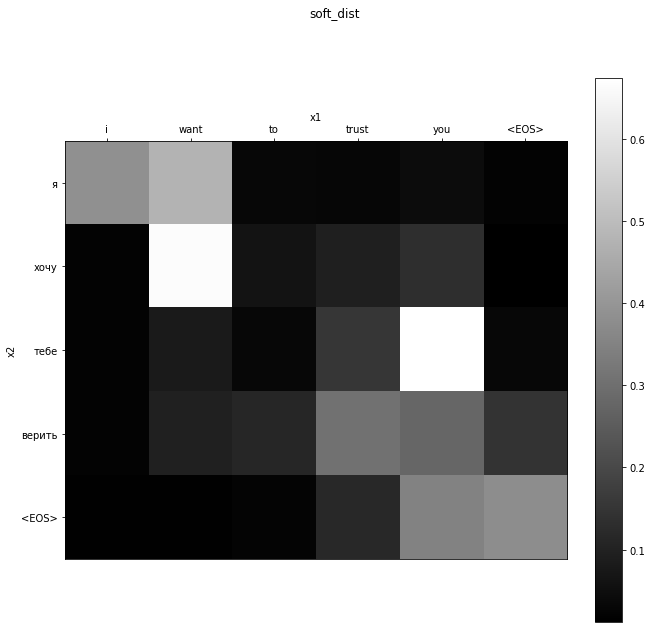

In [406]:
# !pip install optuna
import torch
import optuna
from tqdm.notebook import tqdm
from pprint import pprint
import random
import numpy as np

def objective(trial):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  trial.set_user_attr('device', str(device))
  opt_fn_map = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'Adagrad': optim.Adagrad,
    'ASGD': optim.ASGD,
    'Adamax': optim.Adamax,
    'SparseAdam': optim.SparseAdam,
    'AdamW': optim.AdamW,
    'Adadelta': optim.Adadelta,
    'LBFGS': optim.LBFGS,
    'RMSprop': optim.RMSprop,
    'Rprop': optim.Rprop
  }
  train_config = {
    'seed': trial.suggest_int('seed', 0, 0),
    'n_epoches': trial.suggest_int('n_epoches', 10, 10),
    'lr': trial.suggest_loguniform('lr', 1e-3, 1e-3),
    # 'opt_fn': trial.suggest_categorical('opt_fn', ['SGD', 'Adam', 'Adagrad', 
    #                                           'ASGD', 'Adamax',
    #                                           'AdamW', 'Adadelta',
    #                                           'RMSprop', 'Rprop']),
    'opt_fn': trial.suggest_categorical('opt_fn', ['Adam']),
    'batch_size': trial.suggest_int('batch_size', 300, 300),
    'weight_decay': trial.suggest_loguniform('weight_decay', 0.0, 0.0)
  }
  model_config = {
    'enc_num_embeddings': len(eng_rus.x1_w2i),
    'enc_embedding_dim': trial.suggest_int('enc_embedding_dim', 300, 300),
    'enc_padding_idx': eng_rus.x1_w2i['<PAD>'],
    'dec_num_embeddings': len(eng_rus.x2_w2i),
    'dec_embedding_dim': trial.suggest_int('dec_embedding_dim', 300, 300),
    'dec_padding_idx': eng_rus.x2_w2i['<PAD>'],
    'rnn_type': trial.suggest_categorical('rnn_type', ['RNN']),
    # 'rnn_type': trial.suggest_categorical('rnn_type', ['RNN']),
    'hidden_size': trial.suggest_int('hidden_size', 300, 300),
    'num_layers': trial.suggest_int('num_layers', 1, 1),
    'bidirectional': trial.suggest_categorical('bidirectional', [False]),
    # 'bidirectional': trial.suggest_categorical('bidirectional', [True]),
    'enc_dropout': trial.suggest_uniform('enc_dropout', 0.0, 0.0),
    'dec_dropout': trial.suggest_uniform('dec_dropout', 0.0, 0.0),
    'enc_rnn_dropout': trial.suggest_uniform('enc_rnn_dropout', 0.0, 0.0),
    'dec_rnn_dropout': trial.suggest_uniform('dec_rnn_dropout', 0.0, 0.0),
    'attn_type': trial.suggest_categorical('attn_type', ['soft_dist']),
    # 'attn_type': trial.suggest_categorical('attn_type', ['dot', 'dist', 'soft_dot', 'soft_dist', 'cos', 'soft_cos', 'none']),
    'out_hidden': trial.suggest_int('out_hidden', 600, 600),
    'pack': trial.suggest_categorical('pack', [True]),
  }
  # train
  seed = train_config['seed']
  opt_fn = train_config['opt_fn']
  lr = train_config['lr']
  n_epoches = train_config['n_epoches']
  batch_size = train_config['batch_size']
  weight_decay = train_config['weight_decay']
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  model = EncoderDecoder(**model_config).to(device)
  if opt_fn not in ['Rprop']:
    opt = opt_fn_map[opt_fn](model.parameters(), lr=lr, 
                             weight_decay=weight_decay)
  else:
    opt = opt_fn_map[opt_fn](model.parameters(), lr=lr)
  loss_fn = torch.nn.NLLLoss(ignore_index=eng_rus.x2_w2i['<PAD>'])
  train_dl, test_dl, val_dl = train_test_val_split(eng_rus, 
                                                   batch_size=batch_size)
  pprint(trial.params)
  pbar_epoch = tqdm(range(n_epoches))
  for i in tqdm(pbar_epoch):
    # train
    model.train()
    pbar_train = tqdm(train_dl)
    accs = []
    for x1, x2 in pbar_train:
      opt.zero_grad()
      x1.to(device)
      x2.to(device)
      t = x2[:,1:].flatten(0)
      y2, attn = model(x1, x2)
      p = y2[:,:-1,:].flatten(0, 1)
      loss = loss_fn(p, t)
      loss.backward()
      opt.step()
      with torch.no_grad():
        idx = torch.nonzero(t).view(-1)
        acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
        accs.append(acc)
      pbar_train.set_description(f'epoch: {i+1}, loss: {loss:.3f}, acc: {acc:.3f}')
    # y2d = map(eng_rus.decode_x2, torch.argmax(y2[:,:-1,:], 2).cpu().numpy())
    # x2d = map(eng_rus.decode_x2, x2[:,1:].cpu().numpy())
    # x1d = map(eng_rus.decode_x1, x1[:,1:].cpu().numpy())
    # triples = list(zip(x1d, x2d, y2d))
    # pprint(triples)
    # validation
    model.eval()
    val_accs = []
    with torch.no_grad():
      pbar_val = tqdm(val_dl)
      for x1, x2 in pbar_val:
        x1.to(device)
        x2.to(device)
        t = x2[:,1:].flatten(0)
        y2, attn = model(x1, x2)
        p = y2[:,:-1,:].flatten(0, 1)
        val_loss = loss_fn(p, t)
        idx = torch.nonzero(t).view(-1)
        val_acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
        val_accs.append(val_acc)
      pbar_val.set_description(f'epoch: {i+1}, val_loss: {val_loss:.3f}, val_acc: {val_acc:.3f}')
    m_acc = sum(accs)/len(accs)
    m_val_acc = sum(val_accs)/len(val_accs)
    pbar_epoch.set_description(f'loss: {loss:.3f}, acc: {m_acc:.3f} vloss: {val_loss:.3f}, vacc: {m_val_acc:.3f}')
    trial.report(loss, step=i+1)
    torch.save({'epoch': i,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'model_config': model_config,
                'train_config': train_config},
                'model.pth')
    try:
      uploaded = drive.CreateFile({'title': 'model.pth'})
      uploaded.SetContentFile('model.pth')
      uploaded.Upload()
    except Exception as e:
      print(e)
  # test
  model.eval()
  test_accs = []
  with torch.no_grad():
    pbar_test = tqdm(test_dl)
    for x1, x2 in pbar_test:
      x1.to(device)
      x2.to(device)
      t = x2[:,1:].flatten(0)
      y2, attn = model(x1, x2)
      p = y2[:,:-1,:].flatten(0, 1)
      test_loss = loss_fn(p, t)
      idx = torch.nonzero(t).view(-1)
      test_acc = torch.sum(torch.argmax(p, 1)[idx] == t[idx]).float()/idx.size()[0]
      test_accs.append(test_acc)
    pbar_val.set_description(f'epoch: {i+1}, test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')
  m_test_acc = sum(test_accs)/len(test_accs)
  print(f'mean test_acc: {m_test_acc}')
  if model_config['attn_type'] != 'none':
    plot_attention(attn.clone().cpu().numpy()[:1], 
                    x1.clone().cpu().numpy()[:1], 
                    x2.clone().cpu().numpy()[:1],
                    decoder_x1 = eng_rus.decode_x1,
                    decoder_x2 = eng_rus.decode_x2,
                    figsize=(10, 10),
                    shift=True,
                    mask=True,
                    suptitle=model_config['attn_type'])
  trial.set_user_attr('train_loss', loss.item())
  trial.set_user_attr('val_loss', val_loss.item())
  trial.set_user_attr('test_loss', test_loss.item())
  trial.set_user_attr('train_acc', m_acc.item())
  trial.set_user_attr('val_acc', m_val_acc.item())
  trial.set_user_attr('test_acc', m_test_acc.item())
  y2d = map(eng_rus.decode_x2, torch.argmax(y2[:,:-1,:], 2).cpu().numpy())
  x2d = map(eng_rus.decode_x2, x2[:,1:].cpu().numpy())
  x1d = map(eng_rus.decode_x1, x1[:,1:].cpu().numpy())
  triples = list(zip(x1d, x2d, y2d))[:1]
  pprint(triples)
  return loss

fn = 'optuna.db'
study = optuna.create_study(study_name='16', 
                            direction='minimize', 
                            storage=f'sqlite:///{fn}', 
                            load_if_exists=True)
study.optimize(objective, n_trials=1)
try:
  uploaded = drive.CreateFile({'title': fn})
  uploaded.SetContentFile(fn)
  uploaded.Upload()
except Exception as e:
  print(e)

In [317]:
from pprint import pprint
pprint(study.best_params)
pprint(study.best_value)
pprint(study.best_trial)
pprint(study.direction)
%load_ext google.colab.data_table
study.trials_dataframe()

{'attn_type': 'soft_dist',
 'batch_size': 100,
 'bidirectional': True,
 'dec_dropout': 0.0,
 'dec_embedding_dim': 300,
 'dec_rnn_dropout': 0.0,
 'enc_dropout': 0.0,
 'enc_embedding_dim': 300,
 'enc_rnn_dropout': 0.0,
 'hidden_size': 300,
 'lr': 0.001,
 'n_epoches': 5,
 'num_layers': 1,
 'opt_fn': 'Adam',
 'out_hidden': 600,
 'pack': False,
 'rnn_type': 'RNN',
 'seed': 0,
 'weight_decay': 0.0}
0.13512815535068512
FrozenTrial(number=7, value=0.13512815535068512, datetime_start=datetime.datetime(2020, 5, 9, 0, 16, 11, 937425), datetime_complete=datetime.datetime(2020, 5, 9, 0, 18, 43, 106384), params={'attn_type': 'soft_dist', 'batch_size': 100, 'bidirectional': True, 'dec_dropout': 0.0, 'dec_embedding_dim': 300, 'dec_rnn_dropout': 0.0, 'enc_dropout': 0.0, 'enc_embedding_dim': 300, 'enc_rnn_dropout': 0.0, 'hidden_size': 300, 'lr': 0.001, 'n_epoches': 5, 'num_layers': 1, 'opt_fn': 'Adam', 'out_hidden': 600, 'pack': False, 'rnn_type': 'RNN', 'seed': 0, 'weight_decay': 0.0}, distributions={'

,number,value,datetime_start,datetime_complete,params_attn_type,params_batch_size,params_bidirectional,params_dec_dropout,params_dec_embedding_dim,params_dec_rnn_dropout,params_enc_dropout,params_enc_embedding_dim,params_enc_rnn_dropout,params_hidden_size,params_lr,params_n_epoches,params_num_layers,params_opt_fn,params_out_hidden,params_pack,params_rnn_type,params_seed,params_weight_decay,user_attrs_device,user_attrs_train_acc,user_attrs_train_loss,user_attrs_val_acc,user_attrs_val_loss,state
0,0,0.224853,2020-05-08 23:57:13.972534,2020-05-09 00:00:27.987888,soft_dist,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,GRU,0,0.0,cpu,0.948718,0.224853,0.810056,1.702161,COMPLETE
1,1,0.496093,2020-05-09 00:00:28.019622,2020-05-09 00:02:48.862425,none,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,RNN,0,0.0,cpu,0.901130,0.496093,0.802941,1.955279,COMPLETE
2,2,1.640806,2020-05-09 00:02:48.893567,2020-05-09 00:05:24.323928,none,100,False,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,False,GRU,0,0.0,cpu,0.618384,1.640806,0.577904,2.727423,COMPLETE
3,3,0.586174,2020-05-09 00:05:24.355761,2020-05-09 00:08:51.982904,none,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,LSTM,0,0.0,cpu,0.873846,0.586174,0.780899,1.809779,COMPLETE
4,4,1.023411,2020-05-09 00:08:52.019142,2020-05-09 00:11:12.052000,soft_dist,100,False,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,RNN,0,0.0,cpu,0.728045,1.023411,0.584527,2.836457,COMPLETE
5,5,1.122952,2020-05-09 00:11:12.088577,2020-05-09 00:13:51.048209,soft_dist,100,False,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,GRU,0,0.0,cpu,0.725490,1.122952,0.609827,2.727381,COMPLETE
6,6,0.496093,2020-05-09 00:13:51.081768,2020-05-09 00:16:11.896839,none,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,True,RNN,0,0.0,cpu,0.901130,0.496093,0.802941,1.955279,COMPLETE
7,7,0.135128,2020-05-09 00:16:11.937425,2020-05-09 00:18:43.106384,soft_dist,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,False,RNN,0,0.0,cpu,0.974719,0.135128,0.825215,1.625030,COMPLETE
8,8,0.605857,2020-05-09 00:18:43.144302,2020-05-09 00:22:00.473383,none,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,False,GRU,0,0.0,cpu,0.876833,0.605857,0.820513,1.700572,COMPLETE
9,9,0.334463,2020-05-09 00:22:00.510652,2020-05-09 00:25:50.224702,soft_dist,100,True,0.0,300,0.0,0.0,300,0.0,300,0.001,5,1,Adam,600,False,LSTM,0,0.0,cpu,0.935574,0.334463,0.811268,1.913971,COMPLETE


In [319]:
# optuna.visualization.plot_contour(study, params=['out_hidden', 'attn_type'])
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_parallel_coordinate(study)  # BUG
optuna.visualization.plot_intermediate_values(study)

In [402]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load('model.pth')

model = EncoderDecoder(**checkpoint['model_config']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
with torch.no_grad():
  x1 = eng_rus.encode_x1(normalize('i am tom'))
  print(eng_rus.decode_x1(x1))
  x1 = torch.tensor([x1]).to(device)
  x2 = torch.tensor([[eng_rus.x2_w2i['<GO>']]]).to(device)
  cnt = 0
  while x2.item() != eng_rus.x2_w2i['<EOS>'] and cnt < 10:
    # print(x1)
    # print(x2)
    y2, attn = model(x1, x2)
    # print(y2)
    p = torch.argmax(y2, 2)
    x2 = p
    print(eng_rus.decode_x2([p.item()]))
    cnt += 1

# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# model.eval()
# # - or -
# model.train()

['<GO>', 'i', 'am', 'tom', '<EOS>']
['я']
['позвонил']
['<EOS>']


In [397]:
import sacrebleu

translated = []
target = []

for source, target_ in test:
  translated.append(translate(model, source, device))
  target.append(target_)

bleu = sacrebleu.corpus_bleu(translated, [target])
print(bleu.score)

ModuleNotFoundError: ignored

In [0]:
!pip install torchviz

In [0]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


from torchviz import make_dot
make_dot(x).view()

In [0]:
torch.manual_seed(0)

# input is of size N x C = 3 x 5
x = torch.randn(2, 2, requires_grad=True)
y = torch.randn(2, 2, requires_grad=True)
# each element in target has to have 0 <= value < C
t = torch.tensor([0, 0])
print(x)
print(nn.Softmax(dim=1)(x))
print(nn.Softmax(dim=1)(y))
print(nn.LogSoftmax(dim=1)(x))
print(t)
# l = -t*log(x) = -1*log(x)
print(nn.NLLLoss(reduction='sum')(nn.LogSoftmax(dim=1)(x), t))
print(nn.CrossEntropyLoss(reduction='sum')(x, t))
# l(divergence x from t) = -t*log(x) - -t*log(t) = -t(log(x)-log(t)) = -t(log(x/t))
print(nn.KLDivLoss(reduction='none')(nn.LogSoftmax(dim=1)(x),
                                     nn.Softmax(dim=1)(y)))
print(nn.KLDivLoss(reduction='sum')(nn.LogSoftmax(dim=1)(x),
                                     nn.Softmax(dim=1)(y)))
print(nn.KLDivLoss(reduction='mean')(nn.LogSoftmax(dim=1)(x),
                                     nn.Softmax(dim=1)(y)))
print(nn.KLDivLoss(reduction='batchmean')(nn.LogSoftmax(dim=1)(x),
                                     nn.Softmax(dim=1)(y)))
# l = abs(x - t)
print(nn.L1Loss(reduction='none')(nn.Softmax(dim=1)(x), nn.Softmax(dim=1)(y)))
# l = (x - t)**2
print(nn.MSELoss(reduction='none')(nn.Softmax(dim=1)(x), nn.Softmax(dim=1)(y)))